# Uso del módulo fordward

En el módulo *forward* se implementan algunas formas de resolución del problema directo de imágenes por microondas de un arreglo circular de antenas. Para el caso analítico solo se considera el caso en que el dispersor es un cilindro centrado. En los casos del método de diferencias finitas (FDTD), elementos finitos (FEM), y el método de los momentos (MoM) se pueden generar geometrías más complejas.

- FDTD está implementado en el software [meep](https://meep.readthedocs.io/en/latest/).

- FEM está implementado en el software [FEniCS](https://fenicsproject.org/)***(IMPLEMENTAR).

- MoM está implementado completo basado en [1]***(IMPLEMENTAR).

Libros y publicaciones:

[1] Xudong Chen, Computational Methods for Electromagnetic Inverse Scattering

[2] Matteo Pastorino, Microwave Imaging


Módulo Python: forward

Autores: Julián Galván & Ramiro Irastorza 

Email: rirastorza@iflysib.unlp.edu.ar


## Módulo forward **COMPLETAR

Breve descripción del módulo. Si se ejecuta solo con la instrucción:

> python3 forward.py

A continuación se comentan varios ejemplos de simulación.

## Ejemplo de uso para calibración

### Conversión de parámetros $S_{12}$ a campo eléctrico $E_{z}$ y calibración

El coeficiente de transmisión entre antena transmisora (tx) y receptora (tr) se denomina parámetro $S_{12}$. Como los algoritmos de reconstrucción de imágenes siempre utilizan el campo eléctrico entonces es necesario traducir la información medida ($S_{12}$) a la teórica ($E_{z}$, en nuestro caso porque utilizamos algorimos 2D en configuración TM). Según Ostadrahimi M. y otros (2011) [enlace](https://www.researchgate.net/profile/Amer_Zakaria/publication/224257030_Analysis_of_Incident_Field_Modeling_and_IncidentScattered_Field_Calibration_Techniques_in_Microwave_Tomography/links/0912f50a51f7a51be0000000.pdf), esto se puede hacer calculando los coeficientes de calibración ($c_{F}$) en cada uno de los **receptores** para cada uno de los **transmisores**. Con el cálculo de estos coeficientes también se pueden compesar algunos otros errores debido a diferentes longitudes de camino. Se puede hacer de dos maneras:

1. Con el campo incidente. La expresión en este caso es la siguiente:

$$c_{F_{ls}} = \dfrac{E_{esperado}^{inc}}{S_{medido}^{inc}}$$

donde $E_{esperado}^{inc}$ es el campo simulado o calculado analíticamene en cada receptor y $S_{medido}^{inc}$ el coeficiente de dispersión medido. El subíndice _ls_ es de line source.

2. Con el campo disperso por un medio canónico, por ejemplo, cilindro centrado en (0,0) con dieléctrico conocido. Se reemplaza _inc_ por el _sct_, es decir, el campo eléctrico calculado y el coeficiente de dispersión con en el centro (_problema canónico_).

En este jupyter notebook vamos a calcular las dos formas. Vamos utilizar los $S_{medido}$ con nuestro setup experimental y además también vamos a simular los parámetros $S$ en 3D con FEM, luego compararemos con los valores obtenidos con simulación 2D de los campos eléctricos simulados con FDTD.

### Simulación

En lo que sigue, simularemos tanto el campo incidente (sólo con el medio de acoplamiento) y el campo con el cilindro canónico (cilindro de teflón de diámetro 25 mm centrado en (0,0)). A continuación, mostramos cómo hacer la simulación con la librería _forward_.

In [1]:
from forward import *
import time as tm
import os
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt

Iniciamos el contador para estimar cuanto tarda la simulación del modelo.

In [2]:
start_time = tm.strftime('%H:%M:%S')

Se define la frecuencia, el tamaño de la caja de simulación 25 cm x 25 cm, donde está el arreglo de n antenas (en el ejemplo 4 antenas). Se crean los objetos _TRANSMISOR_parameters_ y _ACOPLANTE_parameters_ y se les asignan las propiedades. Estos objetos contienen información del arreglo de antenas y del fluido de acoplamiento, respectivamente. El acoplante, en este ejemplo, es agua con sal cuyo modelo dieléctrico es un Debye (una frecuencia de relajación) con conductividad iónica.

frecuencia de medición (GHz):  1.1


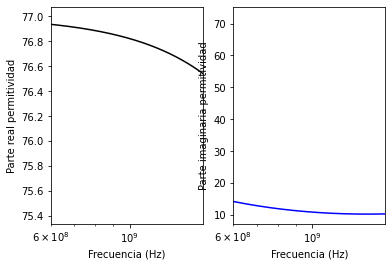

In [3]:
f = 1.1e9
print('frecuencia de medición (GHz): ',f/1e9)
sx = 0.25
sy = 0.25
box = [sx,sy]

TRANSMISOR_parameters = TRANSMISOR_parameters()
TRANSMISOR_parameters.f = f
TRANSMISOR_parameters.amp = 10000.
TRANSMISOR_parameters.rhoS = 0.075
TRANSMISOR_parameters.S = 4.

#Debye para graficar
frel = 20e9
sigmadc = 400e-3
frec = N.linspace(100e6,3e9,1000)#para dibujar
epsc = 4.8+(77.0-4.8)/(1+1j*frec/frel)+sigmadc/(1j*eps0*2*pi*frec)#para dibujar

fig2 = plt.figure(1)
ax1 = fig2.add_subplot(121)
ax1.semilogx(frec,epsc.real,'-k')
ax1.set_xlim([0.6e9, 1.6e9])
ax1.set_ylabel('Parte real permitividad')
ax1.set_xlabel('Frecuencia (Hz)')
ax2 = fig2.add_subplot(122)
ax2.semilogx(frec,-epsc.imag,'-b')
ax2.set_xlim([0.6e9, 1.6e9])
ax2.set_ylabel('Parte imaginaria permitividad')
ax2.set_xlabel('Frecuencia (Hz)')

#Definición de Debye para simular:
epsc = 4.8+(77.0-4.8)/(1+1j*TRANSMISOR_parameters.f/frel)+sigmadc/(1j*eps0*2*pi*TRANSMISOR_parameters.f)
ACOPLANTE_parameters = ACOPLANTE_parameters()
ACOPLANTE_parameters.f = TRANSMISOR_parameters.f
ACOPLANTE_parameters.epsr = epsc.real 
ACOPLANTE_parameters.sigma = -epsc.imag*(eps0*2*pi*TRANSMISOR_parameters.f)
plt.show()

Luego se define el cilindro dispersor pasando los parámetros al objeto _SCATTERER_parameters_. El cilindro está centrado en (0,0) y es de teflon (permitividad relativa 2.1 y conductividad nula). Aquí también lo dibujamos, junto con el arreglo de antenas.

Xc: 0.0 Yc: 0.0 r: 0.0125
Permitividad medio: 76.7822536826101
Conductividad medio: 0.642275452117437
Permitividad del cilindro: 2.1
Conductividad del cilindro: 0.0


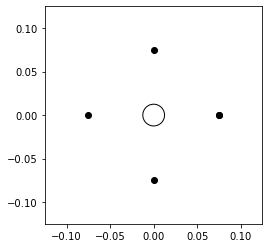

In [4]:
#Coordenadas antenas
angulo = N.linspace(0.0, 2.0*pi, 5)
xantenas = (TRANSMISOR_parameters.rhoS)*N.cos(angulo)
yantenas = (TRANSMISOR_parameters.rhoS)*N.sin(angulo)

#Generación de modelos
r = 25.0e-3/2.0
Xc = 0.0
Yc = 0.0

print('Xc:', Xc,'Yc:', Yc,'r:',r)

#Dibujo la geometría generada
cilindro = plt.Circle((Xc,Yc),r,fill = False)

#Cargo los parámetros del cilindro
cilindro1 = SCATTERER_parameters()
cilindro1.epsr = 2.1 #permitividad relativa. Entre [10.0, 80.0]
cilindro1.sigma = 0.0
cilindro1.f = TRANSMISOR_parameters.f #frecuencia 1.0 GHz (por defecto).
cilindro1.radio = r
cilindro1.xc = Xc
cilindro1.yc = Yc

print('Permitividad medio:',ACOPLANTE_parameters.epsr)
print('Conductividad medio:',ACOPLANTE_parameters.sigma)

print('Permitividad del cilindro:',cilindro1.epsr)
print('Conductividad del cilindro:',cilindro1.sigma)

figure, axes = plt.subplots()
plt.xlim(-0.25/2, 0.25/2)
plt.ylim(-0.25/2 , 0.25/2)
axes.set_aspect(1)
axes.add_artist(cilindro)
axes.plot(xantenas,yantenas,'ok')
plt.show()

Ahora simulamos, utilizando el transmisor número 2 (_tx = 2_) luego seleccionamos el campo en el receptor 0 (_t_r=0_). De esta manera obtenemos $E_{esperado}^{inc}$ y $E_{esperado}^{sct}$.

sxa:  50.0 sxa:  50.0
-----------
Initializing structure...
time for choose_chunkdivision = 0.000200987 s
Working in 2D dimensions.
Computational cell is 50 x 50 x 0 with resolution 5
     cylinder, center = (0,0,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.1,2.1,2.1)
time for set_epsilon = 0.0416849 s
time for set_conductivity = 0.00306797 s
time for set_conductivity = 0.00319409 s
time for set_conductivity = 0.00309205 s
-----------
Meep: using complex fields.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Meep progress: 228.3/1500.0 = 15.2% done in 4.0s, 22.3s to go
on time step 2320 (time=232), 0.00172497 s/step
Meep progress: 497.70000000000005/1500.0 = 33.2% done in 8.0s, 16.1s to go
on time step 5022 (time=502.2), 0.00148081 s/step
Meep progress: 732.0/1500.0 = 48.8% done in 12.0s, 12.6s to go
on time step 7349 (time=734.9), 0.00171989 s/step
Meep progress: 938.8000000000001/1500.0 = 62.6% done in 16.0s, 9.6s to go
on time step 9432 (time=943.2), 0.00192056 s/step
Meep progress: 1118.8/1500.0 = 74.6% done in 20.0s, 6.8s to go
on time step 11228 (time=1122.8), 0.00222746 s/step
Meep progress: 1276.2/1500.0 = 85.1% done in 24.0s, 4.2s to go
on time step 12787 (time=1278.7), 0.00256673 s/step
run 0 finished at t = 1500.0 (15000 timesteps)
sxa:  50.0 sxa:  50.0
-----------
Initializing structure...
time for choose_chunkdivision = 0.000147104 s
Working in 2D dimensions.
Computational cell is 50 x 50 x 0 with resolution 5
     cylinder, center = (0,0,0)
          radius 2.5, height 1e+20,

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Meep progress: 372.0/1500.0 = 24.8% done in 4.0s, 12.1s to go
on time step 3725 (time=372.5), 0.00107396 s/step
Meep progress: 746.6/1500.0 = 49.8% done in 8.0s, 8.1s to go
on time step 7468 (time=746.8), 0.00106868 s/step
Meep progress: 1126.3/1500.0 = 75.1% done in 12.0s, 4.0s to go
on time step 11270 (time=1127), 0.00105226 s/step
Meep progress: 1360.3000000000002/1500.0 = 90.7% done in 16.0s, 1.6s to go
on time step 13605 (time=1360.5), 0.00171349 s/step
run 0 finished at t = 1500.0 (15000 timesteps)


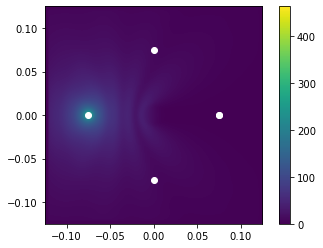

In [5]:
resolucion = 5
n = resolucion*sx/a
tx = 2
Ezfdtd,eps_data = RunMeep(cilindro1,ACOPLANTE_parameters,TRANSMISOR_parameters, tx, box,RES = 5,calibration = False)
Ezfdtdinc,eps_data_no = RunMeep(cilindro1,ACOPLANTE_parameters,TRANSMISOR_parameters, tx, box,RES = 5,calibration = True)

tr = 0
xRint = int(resolucion*((0.15/2)*N.cos(tr*2*pi/4.))/a)+int(n/2) #Coordenada x antena emisora
yRint = int(resolucion*((0.15/2)*N.sin(tr*2*pi/4.))/a)+int(n/2)

EzTr = abs(Ezfdtd)[xRint,yRint]
EzTrinc = abs(Ezfdtdinc)[xRint,yRint]

plt.figure()
extent2=[-0.25/2,0.25/2,-0.25/2,0.25/2]
plt.imshow(abs(Ezfdtd).transpose(),extent = extent2)#cmap = 'binary')
plt.plot(xantenas,yantenas,'ow')
plt.colorbar()

plt.show()

Ahora calculamos los coeficientes de calibración $c_{F_{ls}}^{inc}$ y $c_{F_{ls}}^{sct}$ con los valores medidos en el setup experimental (archivo: _Med_pos_1_pos_3_prueba1.txt_, son las antenas opuestas).

In [6]:
canonico = 'Med_pos_1_pos_3_prueba1.txt'#Cilindro de teflon
datos = np.loadtxt(canonico,skiprows=1)
f_medida = datos[-51,0]
S_medida = datos[-51,1]

csct_F = abs(EzTr)/abs(10**(S_medida/20))

print('c_F :', csct_F)


print('start time: ', start_time)
print('end time:   ', tm.strftime('%H:%M:%S'))

c_F : 442.2165897982208
start time:  10:37:17
end time:    10:38:04


Ahora simulamos el cilindro de Nylon descentrado con lo cual tendremos un valor teórico y, luego, vemos cuál es el valor medido y calibrado con el coeficiente $c_{F_{ls}}^{sct}$.

Xc: -0.025 Yc: -0.025 r: 0.01775
Permitividad medio: 76.7822536826101
Conductividad medio: 0.642275452117437
Permitividad del cilindro: 4.1
Conductividad del cilindro: 0.0


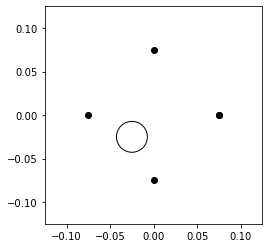

In [7]:
r = 35.5e-3/2.0
Xc = -0.025
Yc = -0.025

print('Xc:', Xc,'Yc:', Yc,'r:',r)

#Dibujo la geometría generada
cilindro = plt.Circle((Xc,Yc),r,fill = False)

#Cargo los parámetros del cilindro
cilindro1 = SCATTERER_parameters()
cilindro1.epsr = 4.1 #permitividad relativa. Entre [10.0, 80.0]
cilindro1.sigma = 0.0
cilindro1.f = TRANSMISOR_parameters.f #frecuencia 1.0 GHz (por defecto).
cilindro1.radio = r
cilindro1.xc = Xc
cilindro1.yc = Yc

print('Permitividad medio:',ACOPLANTE_parameters.epsr)
print('Conductividad medio:',ACOPLANTE_parameters.sigma)

print('Permitividad del cilindro:',cilindro1.epsr)
print('Conductividad del cilindro:',cilindro1.sigma)

figure, axes = plt.subplots()
plt.xlim(-0.25/2, 0.25/2)
plt.ylim(-0.25/2 , 0.25/2)
axes.set_aspect(1)
axes.add_artist(cilindro)
axes.plot(xantenas,yantenas,'ok')
plt.show()

In [8]:
Ezfdtd_sct,eps_data = RunMeep(cilindro1,ACOPLANTE_parameters,TRANSMISOR_parameters, tx, box,RES = 5,calibration = False)
EzTr_sct = abs(Ezfdtd_sct)[xRint,yRint]

sxa:  50.0 sxa:  50.0
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 2D dimensions.
Computational cell is 50 x 50 x 0 with resolution 5
     cylinder, center = (-5,-5,0)
          radius 3.55, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (4.1,4.1,4.1)
time for set_epsilon = 0.041188 s
time for set_conductivity = 0.002918 s
time for set_conductivity = 0.00294995 s
time for set_conductivity = 0.00422406 s
-----------
Meep: using complex fields.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Meep progress: 382.6/1500.0 = 25.5% done in 4.0s, 11.7s to go
on time step 3833 (time=383.3), 0.00104378 s/step
Meep progress: 811.0/1500.0 = 54.1% done in 8.0s, 6.8s to go
on time step 8118 (time=811.8), 0.000933573 s/step
Meep progress: 1248.4/1500.0 = 83.2% done in 12.0s, 2.4s to go
on time step 12491 (time=1249.1), 0.000914886 s/step
run 0 finished at t = 1500.0 (15000 timesteps)


Ahora comparamos con la medición:

In [9]:
canonico = 'Med_pos_1_pos_3_prueba2.txt'#Cilindro de teflon
datos = np.loadtxt(canonico,skiprows=1)
f_medida = datos[-51,0]
S_medida_sct = datos[-51,1]
EzTr_sct_medido = csct_F*abs(10**(S_medida_sct/20))
print('Ez_medido: ',EzTr_sct_medido)
print('Ez_teorico: ',EzTr_sct)

Ez_medido:  1.2791146738779822
Ez_teorico:  3.333979894073625


Si calculamos el coeficiente de calibración con la simulación ($S_{FEM}^{sct}$). Estos coeficientes fueron calculados por simulación con elementos finitos.

$$c_{F_{ls}}^{FEM} = \dfrac{E_{esperado}^{sct}}{S_{FEM}^{sct}}$$


In [10]:
S_fem = -47.4 #dB con teflón
csct_F_FEM = abs(EzTr)/abs(10**(S_fem/20))
S_sct_fem = -47.15
EzTr_sct_FEM = csct_F_FEM*abs(10**(S_sct_fem/20))
print('Ez_calibrado_fem: ',EzTr_sct_FEM)
print('Ez_teorico: ',EzTr_sct)

Ez_calibrado_fem:  1.4490094944772214
Ez_teorico:  3.333979894073625


## Conclusión

